# **Task:2 Fruit Classification Using Transfer Learning**


### Introduction 

In this task, we will classify images of fruits using transfer learning with the pre-trained VGG16 model. Transfer learning enables leveraging a model trained on a large dataset (like ImageNet) and applying it to the dataset with fewer data and computational resources.

### Final output 

The final output will be a trained deep learning model capable of classifying various fruit images into their respective categories. We will also visualize the model's accuracy and predictions on sample test images.


#### Code to suppress warnings


In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="keras.src.trainers.data_adapters.py_dataset_adapter")
warnings.filterwarnings("ignore", category=UserWarning, module="keras.src.trainers.epoch_iterator")

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress all warnings and info messages

### Steps to Perform
To achieve the given task, we will complete the following Steps:

- Step 1: Import necessary libraries and set dataset paths
- Step 2: Set up data generators for training, validation, and testing with augmentation
- Step 3: Define the VGG16-based model architecture with custom layers
- Step 4: Compile the model with appropriate loss and optimizer
- Step 5: Train the model with early stopping and learning rate scheduling
- Step 6: Fine-tune the model by unfreezing specific layers in VGG16
- Step 7: Evaluate the model on the test set and display accuracy
- Step 8: Visualize training performance with accuracy and loss curves
- Step 9: Test model predictions on sample images and visualize results


<h3> Step 1: Import necessary libraries and set dataset paths </h3>


This involves importing essential libraries and setting up the paths for the dataset directories (train, val, and test). These libraries are necessary for data handling, model building, and performance evaluation.

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Set dataset paths
train_dir = './Dataset/fruits-360-original-size/Training'
val_dir = './Dataset/fruits-360-original-size/Validation'
test_dir = './Dataset/fruits-360-original-size/Test'

<h3> Step 2: Set up data generators for training, validation, and testing with augmentation </h3>


Data generators load images from directories, rescale them, and apply augmentation on the training set to help the model generalize better. Validation and test sets are only rescaled (no augmentation).

In [3]:
# Image data generators
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Load images from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(64, 64),
    batch_size=16,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(64, 64),
    batch_size=16,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(64, 64),
    batch_size=16,
    class_mode='categorical'
)


Found 6231 images belonging to 24 classes.
Found 3114 images belonging to 24 classes.
Found 3110 images belonging to 24 classes.


<h3>Step 3: Define the VGG16-based model architecture with custom layers</h3>


This involves loading the pre-trained VGG16 model (excluding the top layers) and adding custom layers to adapt it to the fruit classification task.



In [4]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout

# Load VGG16 with pre-trained weights
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Build the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(train_generator.num_classes, activation='softmax')
])



- `base_model:` Loads VGG16, excluding its dense layers (`include_top=False`).
- `for layer in base_model.layers:` Freezes VGG16 layers to retain pre-trained weights.
- Custom layers: Flatten the output, then add dense layers with regularization (Dropout) and normalization (BatchNormalization) to enhance learning.


<h3>Step 4: Compile the model with appropriate loss and optimizer</h3>


Compile the model to specify the loss function, optimizer, and evaluation metric.

In [5]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)


- `categorical_crossentropy:` Used because this is a multi-class classification task.
- `adam:` Adaptive learning rate optimizer that helps in faster convergence.
- `metrics=['accuracy']:` Tracks model accuracy.

<h3>Step 5: Train the model with early stopping and learning rate scheduling</h3>

Train the model, using callbacks to monitor the validation loss and adjust the learning rate or stop early to prevent overfitting.


In [6]:
import tensorflow as tf
from tensorflow.keras.mixed_precision import set_global_policy

# Define callbacks
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Enable mixed precision (if on GPU)
set_global_policy('float32')

steps_per_epoch = 50 
validation_steps = 25

history = model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator,  
    steps_per_epoch=steps_per_epoch,  
    validation_steps=validation_steps,  
    callbacks=[lr_scheduler, early_stopping]
)

Epoch 1/5
50/50 [==============================] - 55s 1s/step - loss: 2.6705 - accuracy: 0.2362 - val_loss: 2.6327 - val_accuracy: 0.2150 - lr: 0.0010
Epoch 2/5
50/50 [==============================] - 51s 1s/step - loss: 1.6638 - accuracy: 0.5088 - val_loss: 2.0352 - val_accuracy: 0.4775 - lr: 0.0010
Epoch 3/5
50/50 [==============================] - 60s 1s/step - loss: 1.3148 - accuracy: 0.5917 - val_loss: 1.7136 - val_accuracy: 0.5575 - lr: 0.0010
Epoch 4/5
50/50 [==============================] - 53s 1s/step - loss: 1.1190 - accuracy: 0.6513 - val_loss: 1.4375 - val_accuracy: 0.5925 - lr: 0.0010
Epoch 5/5
50/50 [==============================] - 45s 894ms/step - loss: 0.9900 - accuracy: 0.6812 - val_loss: 1.2808 - val_accuracy: 0.5850 - lr: 0.0010



- `ReduceLROnPlateau`: Reduces learning rate when validation loss plateaus, allowing better optimization.
- `EarlyStopping`: Stops training when validation loss no longer improves, preventing overfitting.
- `model.fit`: Trains the model on the `train_generator` and evaluates on `val_generator` each epoch.


<h3>Step 6: Fine-tune the model by unfreezing specific layers in VGG16</h3>


We will Fine-tune by unfreezing a few layers in the VGG16 base model to allow learning on fruit-specific features.


In [7]:
# Import necessary libraries
import tensorflow as tf  # Import TensorFlow for accessing tf.keras
from tensorflow.keras.optimizers import Adam

# Check the number of layers in the base model
num_layers = len(base_model.layers)
print(f"The base model has {num_layers} layers.")

# Unfreeze the last 5 layers for fine-tuning
for layer in base_model.layers[-5:]:
    layer.trainable = True

# Freeze BatchNorm layers to speed up fine-tuning
for layer in base_model.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False

# Re-compile the model with a faster optimizer
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),   # Higher learning rate for faster convergence
    metrics=['accuracy']
)

# Continue training with fewer steps per epoch
history_fine = model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator,
    steps_per_epoch=steps_per_epoch,  # Reduced steps per epoch
    validation_steps=validation_steps,  # Reduced validation steps
    callbacks=[lr_scheduler, early_stopping]
)

The base model has 19 layers.
Epoch 1/5
50/50 [==============================] - 70s 1s/step - loss: 0.7863 - accuracy: 0.7675 - val_loss: 1.0064 - val_accuracy: 0.6425 - lr: 1.0000e-05
Epoch 2/5
50/50 [==============================] - 70s 1s/step - loss: 0.7139 - accuracy: 0.7762 - val_loss: 0.7580 - val_accuracy: 0.7825 - lr: 1.0000e-05
Epoch 3/5
50/50 [==============================] - 100s 2s/step - loss: 0.6232 - accuracy: 0.8238 - val_loss: 0.6180 - val_accuracy: 0.8200 - lr: 1.0000e-05
Epoch 4/5
50/50 [==============================] - 89s 2s/step - loss: 0.5906 - accuracy: 0.8263 - val_loss: 0.5338 - val_accuracy: 0.8375 - lr: 1.0000e-05
Epoch 5/5
50/50 [==============================] - 66s 1s/step - loss: 0.5321 - accuracy: 0.8462 - val_loss: 0.4588 - val_accuracy: 0.8675 - lr: 1.0000e-05


- `for layer in base_model.layers[-5:]`: Unfreezes the last 5 layers to allow fine-tuning.
-  Unfreezing fewer layers is faster and prevents overfitting on small datasets.
- `RMSprop(learning_rate=1e-5)`: Optimizer with a lower learning rate to fine-tune carefully without drastic weight changes.

<h3>Step 7: Evaluate the model on the test set and display accuracy</h3>


Evaluate the final model on unseen test data to gauge its generalization.

In [8]:
# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(test_generator, steps=50)
print(f"Test Accuracy: {test_accuracy:.2f}")

50/50 [==============================] - 37s 753ms/step - loss: 0.4620 - accuracy: 0.8650
Test Accuracy: 0.87


<h3> Step 8: Visualize training performance with accuracy and loss curves </h3>


Plot the training and validation accuracy and loss to understand the model’s learning progress.

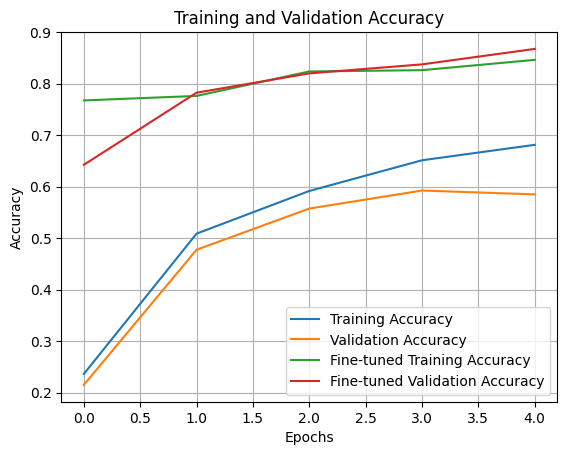

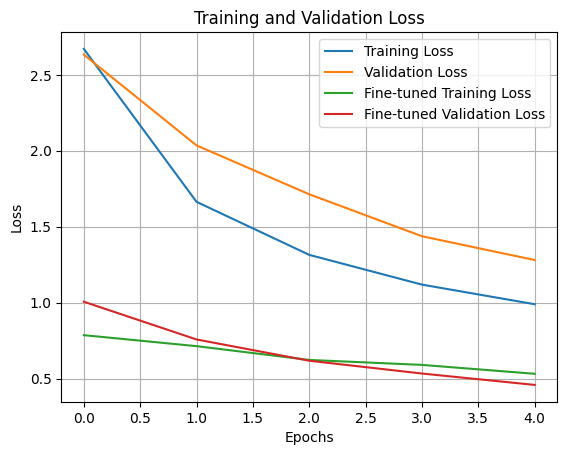

In [9]:
# Plot accuracy and loss curves
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history_fine.history['accuracy'], label='Fine-tuned Training Accuracy')
plt.plot(history_fine.history['val_accuracy'], label='Fine-tuned Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.grid(True)
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history_fine.history['loss'], label='Fine-tuned Training Loss')
plt.plot(history_fine.history['val_loss'], label='Fine-tuned Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.grid(True)
plt.show()

<h3>Step 9: Test model predictions on sample images and visualize results</h3>


Makes predictions on a few test images and displays them with the model's predicted class.

Class Index Mapping: {'apple_6': 0, 'apple_braeburn_1': 1, 'apple_crimson_snow_1': 2, 'apple_golden_1': 3, 'apple_golden_2': 4, 'apple_golden_3': 5, 'apple_granny_smith_1': 6, 'apple_hit_1': 7, 'apple_pink_lady_1': 8, 'apple_red_1': 9, 'apple_red_2': 10, 'apple_red_3': 11, 'apple_red_delicios_1': 12, 'apple_red_yellow_1': 13, 'apple_rotten_1': 14, 'cabbage_white_1': 15, 'carrot_1': 16, 'cucumber_1': 17, 'cucumber_3': 18, 'eggplant_violet_1': 19, 'pear_1': 20, 'pear_3': 21, 'zucchini_1': 22, 'zucchini_dark_1': 23}
1/1 [==============================] - 1s 837ms/step


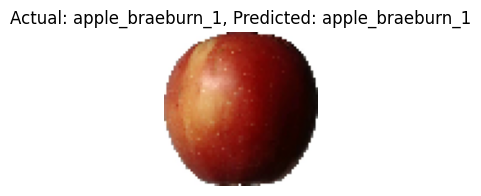

1/1 [==============================] - 0s 96ms/step


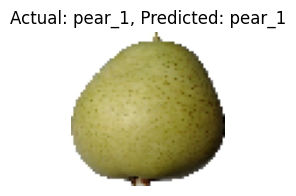

1/1 [==============================] - 0s 105ms/step


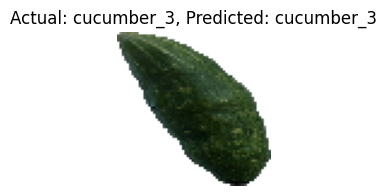

In [10]:
import os
import numpy as np
from collections import Counter
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import matplotlib.pyplot as plt

# Initialize counters for actual and predicted classes
actual_count = Counter()
predicted_count = Counter()

# Function to get class name from predicted index
def get_class_name_from_index(predicted_index, class_index_mapping):
    """Convert predicted index to class name."""
    for class_name, index in class_index_mapping.items():
        if index == predicted_index:
            return class_name
    return "Unknown"  # Default if index is not found

# Define the function for visualization
def visualize_prediction_with_actual(img_path, class_index_mapping):
    # Extract the true label dynamically from the directory structure
    class_name = os.path.basename(os.path.dirname(img_path))  # Extract folder name (class)
    
    # Load and preprocess the image
    img = load_img(img_path, target_size=(64, 64)) 
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict the class
    prediction = model.predict(img_array)
    predicted_index = np.argmax(prediction, axis=-1)[0]
    predicted_class_name = get_class_name_from_index(predicted_index, class_index_mapping)

    # Update the counters
    actual_count[class_name] += 1
    predicted_count[predicted_class_name] += 1

    # Visualize the image with predictions
    plt.figure(figsize=(2, 2), dpi=100)
    plt.imshow(img)
    plt.title(f"Actual: {class_name}, Predicted: {predicted_class_name}")
    plt.axis('off')
    plt.show()

# Retrieve class index mapping from the training generator
class_index_mapping = train_generator.class_indices
print("Class Index Mapping:", class_index_mapping)  # Debugging: Check the mapping

# Define a list of image paths without hardcoded labels
sample_images = [
    './Dataset/fruits-360-original-size/Test/apple_braeburn_1/r0_11.jpg',
    './Dataset/fruits-360-original-size/Test/pear_1/r0_103.jpg',
    './Dataset/fruits-360-original-size/Test/cucumber_3/r0_103.jpg',
]

# Run the predictions and visualization
for img_path in sample_images:
    visualize_prediction_with_actual(img_path, class_index_mapping)

### Conclusion 


In this task, we implemented a fruit classification model using transfer learning with VGG16. By fine-tuning and using data augmentation, we developed a robust classifier that can recognize different fruits. This task demonstrated the efficiency of transfer learning in achieving high accuracy with minimal training data.

## Key Insights : Custom Image Classifier with Transfer Learning  

1. **Transfer Learning Boosts Performance**  
   - Leveraging pre-trained models (MobileNetV2 / ResNet50) reduced training time and improved accuracy compared to training from scratch.  

2. **Data Augmentation Prevents Overfitting**  
   - Random rotations, flips, and zooming helped the model generalize better to unseen data.  

3. **Fine-Tuning Unlocks More Accuracy**  
   - Unfreezing selected layers of the pre-trained model allowed adaptation to the custom dataset, improving classification results.  

4. **Strong Model Performance**  
   - Accuracy curve showed steady improvement with minimal overfitting.  

5. **Practical Value**  
   - Demonstrates how **AI-powered image recognition** can work effectively on small datasets.  
   - Balances **pre-trained knowledge** with **task-specific customization** for real-world use cases.  

---

This project showcases a **modern deep learning workflow**:  
*Pre-trained models + Data Augmentation + Fine-tuning + Model Evaluation*  
